<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the text data to experiment with various Machine Learning algorithms to build a vanilla binary classifier.</span></p>
    </h4>

In [1]:
import warnings

warnings.filterwarnings('ignore')

import random
import re
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer  # word stemmer class
from nltk.tokenize import word_tokenize
from scipy.stats import zscore
from sklearn import metrics
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score,
                             precision_recall_fscore_support)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

tqdm.pandas()
nltk.download('words')

words = set(nltk.corpus.words.words())
nltk.download('stopwords')
nltk.download('wordnet')
lemma = WordNetLemmatizer()
%matplotlib inline
sns.set()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#importing the data
data = pd.read_csv('./data/augmented_upsampled_data.csv')
data.sample(5)

,translated_description,label
16651,drive requires hostname team corporate governa...,0
22080,erp logon balance error cannot be launched,0
6608,skype let sign say address type valid,0
26203,request ns front cd aiming to evaluate theft c...,1
21241,error log skype certificate impossible,0


In [3]:
# reproducibility
seed = 7
random.seed(seed)

In [4]:
import re

def normalizer(text):
    text = " ".join(filter(lambda x: x[0]!= '@' , text.split()))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = re.sub(' +', ' ', text).strip()
    text = text.split()
    text = [words for words in text if not words in set(stopwords.words('english'))]
    text = [lemma.lemmatize(word) for word in text]
    
    text = " ".join(text)
    return text

In [5]:
data['ml_feature'] = data['translated_description'].progress_apply(normalizer)

100%|███████████████████████████████████████████████████████████████████████████| 26218/26218 [01:16<00:00, 341.21it/s]


In [6]:
data.sample(5)

,translated_description,label,ml_feature
19658,Unable to ap remote eu remote wle na remote fj...,0,unable ap remote eu remote wle na remote fjaqb...
16909,lockout access window,0,lockout access window
17789,work work failure work programmer work,0,work work failure work programmer work
6051,zeitwirtschaft seit uhr morgens sind fur wer...,1,zeitwirtschaft seit uhr morgen sind fur werk g...
12932,Sid error in process erp kis kis record miss s...,1,sid error process erp ki ki record miss sf tra...


In [7]:
data['ml_feature'][0]

'verify user detail name check user name ad reset password advise user login check caller confirm able login issue resolve'

In [8]:
#remover duplicate words in a sentence
def uniquify(string):
    output = []
    seen = set()
    for word in string.split():
        if word not in seen:
            output.append(word)
            seen.add(word)
    return ' '.join(output)

In [9]:
data['ml_feature'] = data['ml_feature'].progress_apply(uniquify)

100%|████████████████████████████████████████████████████████████████████████| 26218/26218 [00:00<00:00, 222184.59it/s]


In [10]:
data['ml_feature'][0]

'verify user detail name check ad reset password advise login caller confirm able issue resolve'

In [11]:
data['label'].value_counts(normalize=True) * 100

1    50.0
0    50.0
Name: label, dtype: float64

#### Data pre-processing 

In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])
y_classes_len = len(le.classes_)
le.classes_
print(y_classes_len)

2


In [13]:
def mytokenizer(x):
    return [y for y in x.split() if len(y) > 2]

In [14]:
vec = CountVectorizer(tokenizer=mytokenizer, min_df=0.005)
X = vec.fit_transform(data['ml_feature'])
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

In [15]:
df

,abende,able,access,account,action,active,add,additional,address,advice,...,window,without,wle,work,workflow,working,would,write,wrong,yesterday
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26216,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
s1 = pd.Series(data['label_encoded'], name="label_encoded")

In [17]:
df1 = df.reset_index(drop=True)
s1 = s1.reset_index(drop=True)

In [18]:
result = pd.concat([df1, s1], axis=1)

In [19]:
result.sample(5)

,abende,able,access,account,action,active,add,additional,address,advice,...,without,wle,work,workflow,working,would,write,wrong,yesterday,label_encoded
15832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13161,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
result = result.loc[:,~result.columns.duplicated()]

In [21]:
result.sample(5)

,abende,able,access,account,action,active,add,additional,address,advice,...,without,wle,work,workflow,working,would,write,wrong,yesterday,label_encoded
14867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
#creating a copy of the train data and seperating the target column and the predictor variables

X = result.drop(['label_encoded'],axis=1)
y = result['label_encoded']
X.shape, y.shape

((26218, 441), (26218,))

In [23]:
# splitting data training dataset into train and test set for independent attributes
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.30,  random_state=seed)

In [24]:
# Initializaing various classification algorithms with normal dataset and choosing the best model based on auc score for tuning

models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity=0)))
models.append(("LightGBM",LGBMClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc_ovo', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f%% (%f%%)' % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

LR: 82.802510% (0.962969%)
KNN: 90.203198% (0.583161%)
GNB: 74.311441% (0.996235%)
DT: 89.691339% (0.477348%)
RF: 95.942385% (0.301543%)
GBT: 82.474512% (0.745963%)
XGB: 90.005724% (0.799015%)
LightGBM: 88.262068% (0.721757%)


#### LightGBM with RandomsearchCV

In [25]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [26]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':[1,2,6,12]}

sample = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 2000 define only the absolute maximum
lgb = LGBMClassifier(max_depth=-1, random_state=seed, silent=True, metric='logloss', n_jobs=-1, n_estimators=2000)
gs = RandomizedSearchCV(estimator=lgb,
                        param_distributions=param_test, 
                        n_iter=sample,
                        cv=5,
                        refit=True,
                        random_state=seed,
                        verbose=True)

gs.fit(X_train, Y_train)
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'colsample_bytree': 0.6751685445687777,
 'min_child_samples': 140,
 'min_child_weight': 0.1,
 'num_leaves': 24,
 'reg_alpha': 0.1,
 'reg_lambda': 20,
 'scale_pos_weight': 2,
 'subsample': 0.4946857565935163}

In [27]:
lgb = LGBMClassifier(colsample_bytree=gs.best_params_['colsample_bytree'],
                   min_child_samples=gs.best_params_['min_child_samples'],
                   min_child_weight=gs.best_params_['min_child_weight'],
                   num_leaves=gs.best_params_['num_leaves'],
                   reg_alpha=gs.best_params_['reg_alpha'],
                   reg_lambda=gs.best_params_['reg_lambda'],
                   scale_pos_weight=gs.best_params_['scale_pos_weight'],
                   subsample=gs.best_params_['subsample'])
lgb.fit(X_train, Y_train)

LGBMClassifier(colsample_bytree=0.6751685445687777, min_child_samples=140,
               min_child_weight=0.1, num_leaves=24, reg_alpha=0.1,
               reg_lambda=20, scale_pos_weight=2, subsample=0.4946857565935163)

In [28]:
modellgb1 = lgb.score(X_train, Y_train)
print('Accuracy Score of Training Data: ', modellgb1)

Accuracy Score of Training Data:  0.7276591107236269


In [29]:
y_predictlg1= lgb.predict(X_test)
modellg1 = accuracy_score(Y_test, y_predictlg1)
print('Accuracy Score of Test Data:', modellg1)

Accuracy Score of Test Data: 0.7140859394863972


In [30]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictlg1, labels=[0,1]))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      3922
           1       0.65      0.92      0.76      3944

    accuracy                           0.71      7866
   macro avg       0.76      0.71      0.70      7866
weighted avg       0.76      0.71      0.70      7866



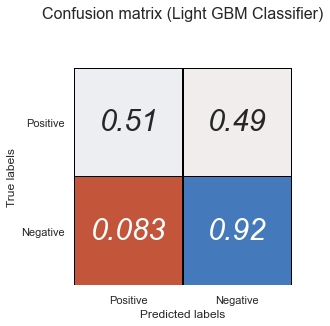

In [31]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names  = ['Positive', 'Negative'], vmax=None,
                           normalized=True, title='Confusion matrix'):
    """
    Helper fuction to generate a clean Confusion Matrix using seaborn library.
    y_true: True labels, y_pred: Model Predictions, class_names: Override if needed
    normalized: True, gives the proportions instead of absolute numbers
    """
    matrix = confusion_matrix(y_true,y_pred)
    if normalized:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    annot_kws = {'fontsize':30, 
                'fontstyle': 'italic'}
    sns.heatmap(matrix, vmax=vmax, annot=True,  annot_kws = annot_kws,
                square=True, ax=ax, cbar=False,
                cmap=sns.diverging_palette(20, 250, as_cmap=True), 
                linecolor='black', linewidths=0.5,
                xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)
    
fig, axis1 = plt.subplots(nrows=1, ncols=1)

plot_confusion_matrix(Y_test, y_predictlg1, ax=axis1, title='Confusion matrix (Light GBM Classifier)')

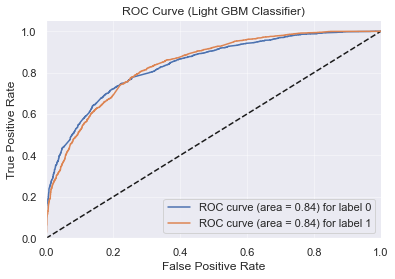

In [33]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6), title='ROC Curve'):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.savefig('ROC_Curve_RF.png')
    plt.show()

plot_multiclass_roc(lgb, X_test, Y_test, n_classes=2, figsize=(6, 4), title='ROC Curve (Light GBM Classifier)')

#### XGBoost with RandomsearchCV

In [34]:
xgb_para = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
           }

xgb = XGBClassifier()
xgb_hy = RandomizedSearchCV(estimator=xgb,
                            param_distributions=xgb_para,
                            cv=5,
                            verbose=2,
                            random_state=seed,
                            n_jobs=-1)

xgb_hy.fit(X_train, Y_train)
xgb_hy.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[17:29:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [35]:
xgb=XGBClassifier(min_child_weight=xgb_hy.best_params_['min_child_weight'],
                  max_depth=xgb_hy.best_params_['max_depth'],
                  learning_rate=xgb_hy.best_params_['learning_rate'],
                  gamma=xgb_hy.best_params_['gamma'],
                  colsample_bytree=xgb_hy.best_params_['colsample_bytree'],
                  random_state=seed)

xgb.fit(X_train,Y_train)

[17:29:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
modelxgb_score = xgb.score(X_train,Y_train)
print('Accuracy Score of Training Data: ', modelxgb_score)

Accuracy Score of Training Data:  0.8717306015693113


In [37]:
y_predictxg = xgb.predict(X_test)
modelxg_score = accuracy_score(Y_test, y_predictxg)
print('Accuracy Score of Test Data:', modelxg_score)

Accuracy Score of Test Data: 0.8396898042206967


In [38]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictxg, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      3922
           1       0.83      0.86      0.84      3944
           2       0.00      0.00      0.00         0

   micro avg       0.84      0.84      0.84      7866
   macro avg       0.56      0.56      0.56      7866
weighted avg       0.84      0.84      0.84      7866



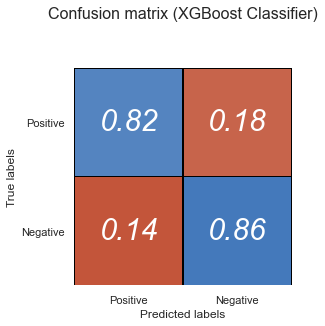

In [39]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(Y_test, y_predictxg, ax=axis1, title='Confusion matrix (XGBoost Classifier)')

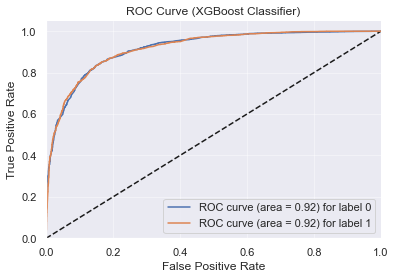

In [40]:
plot_multiclass_roc(xgb, X_test, Y_test, n_classes=2, figsize=(6, 4), title='ROC Curve (XGBoost Classifier)')

#### Random forest with RandomsearchCV

In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = range(2,100,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':['gini','entropy']}

In [42]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               cv=5,
                               verbose=2,
                               random_state=seed,
                               n_jobs=-1)
rf_random.fit(X_train, Y_train)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 279,
 'min_samples_split': 42,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'criterion': 'gini',
 'bootstrap': False}

In [43]:
rf_grid1 = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'],
                                  min_samples_split=rf_random.best_params_['min_samples_split'],
                                  min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
                                  max_features=rf_random.best_params_['max_features'],
                                  max_depth=rf_random.best_params_['max_depth'],
                                  criterion=rf_random.best_params_['criterion'],
                                  bootstrap=rf_random.best_params_['bootstrap'])
rf_grid1.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_split=42, n_estimators=279)

In [44]:
modelrfg1_score = rf_grid1.score(X_train, Y_train)
print('Accuracy Score of Training Data: ', modelrfg1_score)

Accuracy Score of Training Data:  0.9145597210113339


In [45]:
y_predictrfg1 = rf_grid1.predict(X_test)
modelrfg1_score = accuracy_score(Y_test, y_predictrfg1)
print('Accuracy Score of Test Data:', modelrfg1_score)

Accuracy Score of Test Data: 0.8718535469107551


In [46]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(Y_test, y_predictrfg1, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3922
           1       0.85      0.90      0.88      3944
           2       0.00      0.00      0.00         0

   micro avg       0.87      0.87      0.87      7866
   macro avg       0.58      0.58      0.58      7866
weighted avg       0.87      0.87      0.87      7866



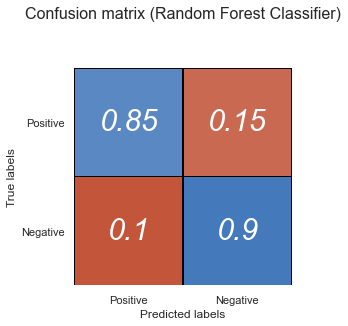

In [47]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(Y_test, y_predictrfg1, ax=axis1, title='Confusion matrix (Random Forest Classifier)')

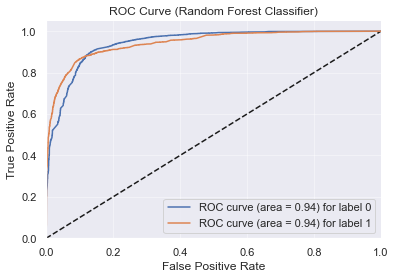

In [48]:
plot_multiclass_roc(rf_grid1, X_test, Y_test, n_classes=2, figsize=(6, 4), title='ROC Curve (Random Forest Classifier)')

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Resultant Metrics: </span></strong></li>
</ul></h3>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>LightGBM Classifier</td>
    <td>71.41%</td>
  </tr>
<tr>
    <td>XGBoost Classifier</td>
    <td>83.97%</td>
  </tr>
    <tr>
    <td>Random Forest Classifier</td>
    <td>87.19%</td>
  </tr>
</table>